# Libraries

In [361]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error 

import matplotlib.pyplot as plt

import os

import datetime as dt

import seaborn as sns

import pandas as pd

import sklearn 
from sklearn.preprocessing import MinMaxScaler

import numpy as np

import pickle

from modules import create_model, preprocessor, plotting_loss_metrics, Predictor

# Statics

In [2]:
# model path
MODEL_PATH = os.path.join(os.getcwd(), 'model', 'model.h5')

# data path
DATA_PATH_TRAIN = os.path.join(os.getcwd(), 'data', 'cases_malaysia_train.csv')
DATA_PATH_TEST = os.path.join(os.getcwd(), 'data', 'cases_malaysia_test.csv')

# scaler path
SCALER_PATH = os.path.join(os.getcwd(), 'model', 'scaler.pkl')

# logs path
time_stamp = dt.datetime.now().strftime('%Y%m%d-%H%M%S')
LOG_PATH = os.path.join(os.getcwd(), 'logs', time_stamp)

# Data loading

In [3]:
df_train = pd.read_csv(DATA_PATH_TRAIN)
df_train

,date,cases_new,cases_import,cases_recovered,cases_active,cases_cluster,cases_unvax,cases_pvax,cases_fvax,cases_boost,...,cases_60_69,cases_70_79,cases_80,cluster_import,cluster_religious,cluster_community,cluster_highRisk,cluster_education,cluster_detentionCentre,cluster_workplace
0,25/1/2020,4,4,0,4,0,4,0,0,0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,26/1/2020,0,0,0,4,0,0,0,0,0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,27/1/2020,0,0,0,4,0,0,0,0,0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,28/1/2020,0,0,0,4,0,0,0,0,0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,29/1/2020,3,3,0,7,0,3,0,0,0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
675,30/11/2021,4879,24,5168,64978,97,1125,55,3595,104,...,358,165,60,0.0,25.0,0.0,28.0,33.0,0.0,31.0
676,1/12/2021,5439,21,6803,63583,110,1363,54,3900,122,...,387,197,61,0.0,25.0,0.0,8.0,33.0,0.0,31.0
677,2/12/2021,5806,11,7246,62099,339,1325,40,4271,170,...,410,174,59,0.0,14.0,2.0,13.0,148.0,52.0,110.0
678,3/12/2021,5551,23,5301,62303,179,1312,46,4046,147,...,411,167,48,0.0,6.0,0.0,3.0,104.0,0.0,66.0


In [4]:
df_test = pd.read_csv(DATA_PATH_TEST)
df_test

,date,cases_new,cases_import,cases_recovered,cases_active,cases_cluster,cases_unvax,cases_pvax,cases_fvax,cases_boost,...,cases_60_69,cases_70_79,cases_80,cluster_import,cluster_religious,cluster_community,cluster_highRisk,cluster_education,cluster_detentionCentre,cluster_workplace
0,5/12/2021,4298.0,23,4928,61813,136,1017,38,3093,150,...,330,130,49,0,13,3,12,69,0,39
1,6/12/2021,4262.0,15,5894,60139,97,1036,39,3056,131,...,352,141,49,0,10,0,2,30,0,55
2,7/12/2021,4965.0,29,4817,60251,138,1130,46,3642,147,...,395,169,81,0,3,13,39,36,0,47
3,8/12/2021,5020.0,17,4525,60709,154,1162,41,3674,143,...,378,154,43,0,2,3,0,32,1,116
4,9/12/2021,5446.0,20,5427,60700,367,1207,53,4034,152,...,367,161,46,0,0,1,8,153,0,205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,10/3/2022,30787.0,608,26457,314211,282,4454,663,9118,16552,...,1851,905,336,0,0,1,14,153,18,96
96,11/3/2022,32800.0,541,24444,322507,309,4782,773,9122,18123,...,2060,927,361,0,0,3,42,97,58,109
97,12/3/2022,26250.0,545,25089,323618,269,3569,707,7151,14823,...,1724,788,302,0,0,3,42,97,58,109
98,13/3/2022,22535.0,361,25356,320785,163,3222,505,6057,12751,...,1448,700,288,0,0,7,40,8,61,153


## general infos

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 680 entries, 0 to 679
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   date                     680 non-null    object 
 1   cases_new                680 non-null    object 
 2   cases_import             680 non-null    int64  
 3   cases_recovered          680 non-null    int64  
 4   cases_active             680 non-null    int64  
 5   cases_cluster            680 non-null    int64  
 6   cases_unvax              680 non-null    int64  
 7   cases_pvax               680 non-null    int64  
 8   cases_fvax               680 non-null    int64  
 9   cases_boost              680 non-null    int64  
 10  cases_child              680 non-null    int64  
 11  cases_adolescent         680 non-null    int64  
 12  cases_adult              680 non-null    int64  
 13  cases_elderly            680 non-null    int64  
 14  cases_0_4                6

In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   date                     100 non-null    object 
 1   cases_new                99 non-null     float64
 2   cases_import             100 non-null    int64  
 3   cases_recovered          100 non-null    int64  
 4   cases_active             100 non-null    int64  
 5   cases_cluster            100 non-null    int64  
 6   cases_unvax              100 non-null    int64  
 7   cases_pvax               100 non-null    int64  
 8   cases_fvax               100 non-null    int64  
 9   cases_boost              100 non-null    int64  
 10  cases_child              100 non-null    int64  
 11  cases_adolescent         100 non-null    int64  
 12  cases_adult              100 non-null    int64  
 13  cases_elderly            100 non-null    int64  
 14  cases_0_4                10

# Data wrangling

## change date to datetime format

In [7]:
df_train['date'] = pd.to_datetime(df_train['date'], format='%d/%m/%Y')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 680 entries, 0 to 679
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     680 non-null    datetime64[ns]
 1   cases_new                680 non-null    object        
 2   cases_import             680 non-null    int64         
 3   cases_recovered          680 non-null    int64         
 4   cases_active             680 non-null    int64         
 5   cases_cluster            680 non-null    int64         
 6   cases_unvax              680 non-null    int64         
 7   cases_pvax               680 non-null    int64         
 8   cases_fvax               680 non-null    int64         
 9   cases_boost              680 non-null    int64         
 10  cases_child              680 non-null    int64         
 11  cases_adolescent         680 non-null    int64         
 12  cases_adult              680 non-nul

In [8]:
df_test['date'] = pd.to_datetime(df_test['date'], format='%d/%m/%Y')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     100 non-null    datetime64[ns]
 1   cases_new                99 non-null     float64       
 2   cases_import             100 non-null    int64         
 3   cases_recovered          100 non-null    int64         
 4   cases_active             100 non-null    int64         
 5   cases_cluster            100 non-null    int64         
 6   cases_unvax              100 non-null    int64         
 7   cases_pvax               100 non-null    int64         
 8   cases_fvax               100 non-null    int64         
 9   cases_boost              100 non-null    int64         
 10  cases_child              100 non-null    int64         
 11  cases_adolescent         100 non-null    int64         
 12  cases_adult              100 non-null

## change from 'object' data type to 'numeric' data type (for 'cases_new' column in df_train)

In [9]:
df_train['cases_new'] = pd.to_numeric(df_train['cases_new'], errors='coerce')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 680 entries, 0 to 679
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     680 non-null    datetime64[ns]
 1   cases_new                668 non-null    float64       
 2   cases_import             680 non-null    int64         
 3   cases_recovered          680 non-null    int64         
 4   cases_active             680 non-null    int64         
 5   cases_cluster            680 non-null    int64         
 6   cases_unvax              680 non-null    int64         
 7   cases_pvax               680 non-null    int64         
 8   cases_fvax               680 non-null    int64         
 9   cases_boost              680 non-null    int64         
 10  cases_child              680 non-null    int64         
 11  cases_adolescent         680 non-null    int64         
 12  cases_adult              680 non-nul

## interpolation 

### for train data

In [10]:
df_train['cases_new'] = df_train['cases_new'].interpolate(method='pad')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 680 entries, 0 to 679
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     680 non-null    datetime64[ns]
 1   cases_new                680 non-null    float64       
 2   cases_import             680 non-null    int64         
 3   cases_recovered          680 non-null    int64         
 4   cases_active             680 non-null    int64         
 5   cases_cluster            680 non-null    int64         
 6   cases_unvax              680 non-null    int64         
 7   cases_pvax               680 non-null    int64         
 8   cases_fvax               680 non-null    int64         
 9   cases_boost              680 non-null    int64         
 10  cases_child              680 non-null    int64         
 11  cases_adolescent         680 non-null    int64         
 12  cases_adult              680 non-nul

### for test data

In [11]:
df_test['cases_new'] = df_test['cases_new'].interpolate(method='pad')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     100 non-null    datetime64[ns]
 1   cases_new                100 non-null    float64       
 2   cases_import             100 non-null    int64         
 3   cases_recovered          100 non-null    int64         
 4   cases_active             100 non-null    int64         
 5   cases_cluster            100 non-null    int64         
 6   cases_unvax              100 non-null    int64         
 7   cases_pvax               100 non-null    int64         
 8   cases_fvax               100 non-null    int64         
 9   cases_boost              100 non-null    int64         
 10  cases_child              100 non-null    int64         
 11  cases_adolescent         100 non-null    int64         
 12  cases_adult              100 non-null

# Basic plotting of the data

## train data

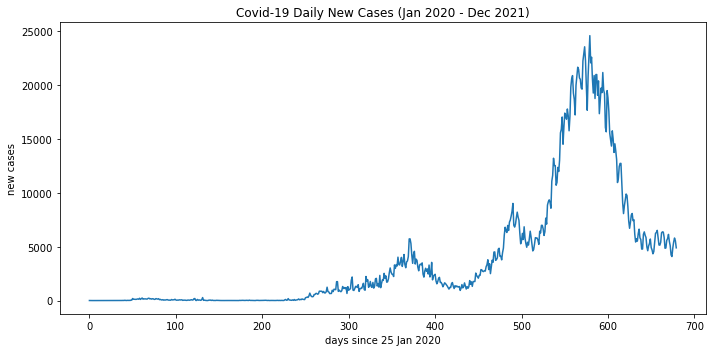

In [12]:
fig, ax =plt.subplots(1, 1, figsize=(10, 5))
df_train['cases_new'].plot.line(ax=ax)
ax.set_title('Covid-19 Daily New Cases (Jan 2020 - Dec 2021)')
ax.set_ylabel('new cases')
ax.set_xlabel('days since 25 Jan 2020')
plt.tight_layout()
plt.show()

## test data

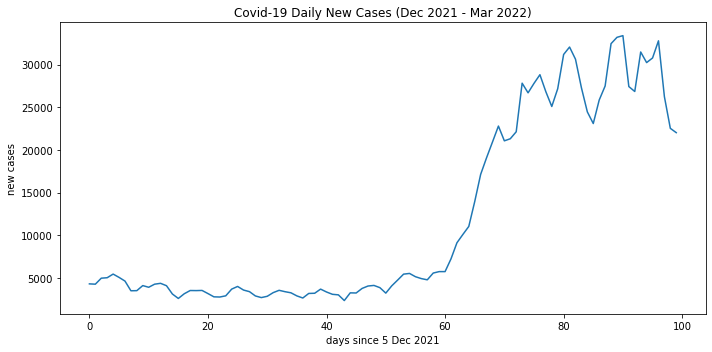

In [13]:
fig, ax =plt.subplots(1, 1, figsize=(10, 5))
df_test['cases_new'].plot.line(ax=ax)
ax.set_title('Covid-19 Daily New Cases (Dec 2021 - Mar 2022)')
ax.set_ylabel('new cases')
ax.set_xlabel('days since 5 Dec 2021')
plt.tight_layout()
plt.show()

# Min-max scale the number of new cases

## for train data

In [14]:
mms = MinMaxScaler()

cases_new_train = mms.fit_transform(df_train[['cases_new']])
cases_new_train.shape

(680, 1)

## for test data

In [15]:
cases_new_test = mms.transform(df_test[['cases_new']])
cases_new_test.shape

(100, 1)

## save the min-max scaler

In [62]:
with open(SCALER_PATH, 'wb') as file:
    pickle.dump(mms, file)

# Combine cases_new_train and cases_new_test for later usage

In [16]:
to_be_concat = (cases_new_train, cases_new_test)
cases_new_combined = np.concatenate(to_be_concat, axis=0)[-130: ]
cases_new_combined.shape

(130, 1)

# Create features and target

## for train data

In [17]:
window_size = 30
X_train = []
y_train = []

for i in range(window_size, cases_new_train.shape[0]):
    X_train.append(cases_new_train[i-window_size: i, 0])
    y_train.append(cases_new_train[i, 0])

X_train = np.array(X_train)
y_train = np.array(y_train)
print(X_train.shape, y_train.shape)

(650, 30) (650,)


## for test data

In [18]:
window_size = 30
X_test = []

for i in range(window_size, cases_new_combined.shape[0]):
    X_test.append(cases_new_combined[i-window_size: i, 0])

X_test = np.array(X_test)
X_test.shape

(100, 30)

In [453]:
y_test = np.copy(cases_new_test)
y_test.shape

(100, 1)

# Deep learning

## create model

In [454]:
input_shape = X_train.shape[-1]
output_shape = 1
drop_rate_1 = 0.3
drop_rate_2 = 0.2
n_lstm = 64

input_1 = Input(shape=(input_shape, 1))

hl_1 = LSTM(n_lstm, return_sequences=True)(input_1)
hl_2 = Dropout(drop_rate_1)(hl_1)
hl_3 = LSTM(n_lstm)(hl_2)
hl_4 = Dropout(drop_rate_2)(hl_3)

output_1 = Dense(output_shape, activation='selu', kernel_initializer='lecun_normal')(hl_4)

model = Model(inputs=input_1, outputs=output_1)

## model summary

In [455]:
model.summary()

Model: "functional_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_34 (InputLayer)        [(None, 30, 1)]           0         
_________________________________________________________________
lstm_106 (LSTM)              (None, 30, 64)            16896     
_________________________________________________________________
dropout_64 (Dropout)         (None, 30, 64)            0         
_________________________________________________________________
lstm_107 (LSTM)              (None, 64)                33024     
_________________________________________________________________
dropout_65 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_46 (Dense)             (None, 1)                 65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________

## model plot

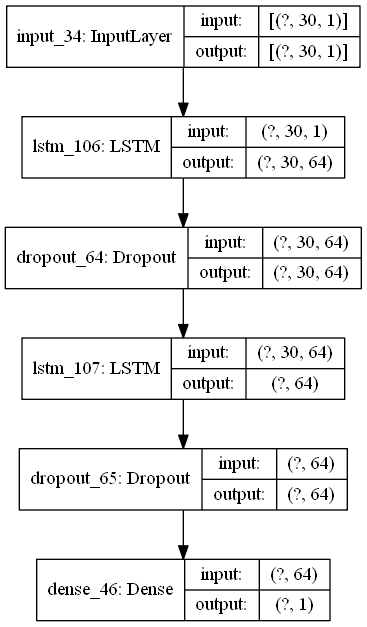

In [466]:
plot_model(model, show_shapes=True, show_layer_names=True)

## compile model

In [457]:
model.compile(optimizer='adam', 
              loss='mse', 
              metrics=[mean_absolute_percentage_error])

## callbacks

In [458]:
tensorboard_callback = TensorBoard(log_dir=LOG_PATH)
early_stopping_callback = EarlyStopping(monitor='loss', patience=3, mode='min', verbose=1)

## model fitting/training with History object

In [459]:
model_hist = model.fit(X_train, 
                       y_train, 
                       epochs=100,
                       batch_size=65,
                       callbacks=[tensorboard_callback, early_stopping_callback])

Epoch 1/100
10/10 [==============================] - 1s 91ms/step - loss: 0.0388 - mean_absolute_percentage_error: 519837.5312
Epoch 2/100
10/10 [==============================] - 1s 71ms/step - loss: 0.0089 - mean_absolute_percentage_error: 327162.7188
Epoch 3/100
10/10 [==============================] - 0s 49ms/step - loss: 0.0048 - mean_absolute_percentage_error: 93523.4375
Epoch 4/100
10/10 [==============================] - 1s 59ms/step - loss: 0.0039 - mean_absolute_percentage_error: 60156.0430
Epoch 5/100
10/10 [==============================] - 0s 46ms/step - loss: 0.0037 - mean_absolute_percentage_error: 65703.3516
Epoch 6/100
10/10 [==============================] - 0s 48ms/step - loss: 0.0033 - mean_absolute_percentage_error: 101875.0625
Epoch 7/100
10/10 [==============================] - 0s 48ms/step - loss: 0.0027 - mean_absolute_percentage_error: 48770.1680
Epoch 8/100
10/10 [==============================] - 0s 45ms/step - loss: 0.0022 - mean_absolute_percentage_error: 

## plot the loss and metrics

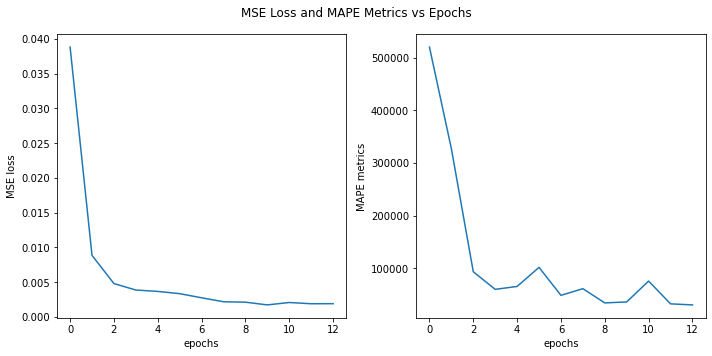

In [460]:
train_loss = model_hist.history['loss']
train_metrics = model_hist.history['mean_absolute_percentage_error']

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('MSE Loss and MAPE Metrics vs Epochs')

ax[0].plot(train_loss)
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('MSE loss')

ax[1].plot(train_metrics)
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('MAPE metrics')

plt.tight_layout()
plt.show()

# Predictions

In [461]:
y_pred = model.predict(np.expand_dims(X_test, axis=-1))
y_pred_actual = mms.inverse_transform(y_pred)
y_test_actual = mms.inverse_transform(y_test)

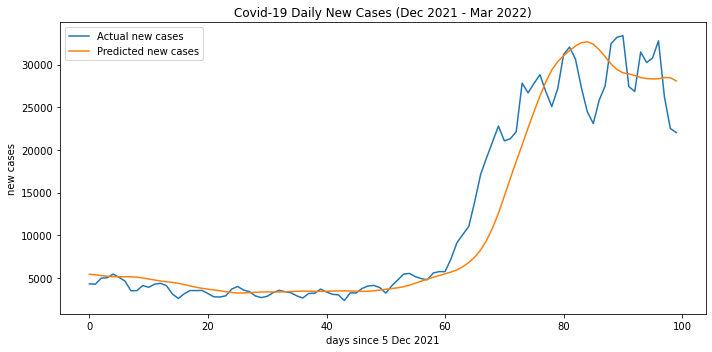

In [462]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.plot(y_test_actual, label='Actual new cases')
ax.plot(y_pred_actual, label='Predicted new cases')
ax.set_title('Covid-19 Daily New Cases (Dec 2021 - Mar 2022)')
ax.set_ylabel('new cases')
ax.set_xlabel('days since 5 Dec 2021')
ax.legend()

plt.tight_layout()
plt.show()

# Performance metrics

In [463]:
mse = mean_squared_error(y_test_actual[0: , 0], y_pred_actual[0: , 0])
mae = mean_absolute_error(y_test_actual[0: , 0], y_pred_actual[0: , 0])
mape = mean_absolute_percentage_error(y_test_actual[0: , 0], y_pred_actual[0: , 0])

print(f'MSE is {mse}\nMAE is {mae}\nMAPE is {mape}')

MSE is 10801527.0
MAE is 2075.31005859375
MAPE is 17.952632904052734


# Save the best model

In [467]:
model.save(MODEL_PATH)

# Tensorboard

In [464]:
# %load_ext tensorboard

In [465]:
# %tensorboard --logdir logs